In [2]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy import stats
from numba import jit

m = 1
size = 50
omega = 0.0001
eps = 1
hbar = 1
L = 1
tiny = 1e-60

a = m / (2*np.pi*hbar)*omega/L**2*np.pi*eps**2
print(a)

@jit(nopython=True)
def step_like(x):
    if x > 0:
        return 1
    else:
        return 1000*x

@jit
def get_funcderivatives(vx, vy, vz, nav,rho):
    # get the derivatives needed for curls and such
    gradvx = np.array(np.gradient(vx))
    gradvy = np.array(np.gradient(vy))
    gradvz = np.array(np.gradient(vz))
    
    curlvx = gradvz[1,:,:,:] - gradvy[2,:,:,:]
    curlvy = -1*gradvz[0,:,:,:] + gradvx[2,:,:,:]
    curlvz = gradvy[0,:,:,:] - gradvx[1,:,:,:]
    
    # get the d/(dvx/dy) part first
    dvxdy = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i-(size-1)/2,j-(size-1)/2,k-(size-1)/2], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = (-1*np.inner(pos,curly)*pos[2]/((i-(size-1)/2)**2+(j-(size-1)/2)**2+(k-(size-1)/2)**2) - (2*omega + curly[2]))/np.absolute(2*omega + curly[2])
                dvxdy[i,j,k] = 2*rho[i,j,k]*step_like(np.sqrt(np.pi*nav[i,j,k])**(-1))*(-2*np.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart + nav[i,j,k]**2*np.log(np.pi*eps**2*nav[i,j,k])/(2*omega + curly[2])**2*np.sign(2*omega + curly[2])
    
    # get the d/(dvx/dz) part next
    dvxdz = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i-(size-1)/2,j-(size-1)/2,k-(size-1/2)], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = -1*np.inner(pos,curly)*pos[1]/((i-(size-1)/2)**2+(j-(size-1)/2)**2+(k-(size-1)/2)**2)/np.absolute(2*omega + curly[2])
                dvxdz[i,j,k] = rho[i,j,k]*step_like(np.sqrt(np.pi*nav[i,j,k])**(-1))*(-2*math.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart
                            

    funcdx = -1*np.array(np.gradient(dvxdy,axis=1)) - np.array(np.gradient(dvxdz,axis=2)) + rho*m**2/(2*np.pi*hbar**2)*vx
    # done with vx!
                              
    # get the d/(dvx/dy) part first
    dvydx = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i-(size-1)/2,j-(size-1)/2,k-(size-1)/2], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = 1 + np.inner(pos,curly)*curly[2]/((i-(size-1)/2)**2+(j-(size-1)/2)**2+(k-(size-1)/2)**2)/np.absolute(2*omega + curly[2])
                dvydx[i,j,k] = rho[i,j,k]*step_like(1.0/np.sqrt(np.pi*nav[i,j,k]))*(-2*math.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart - nav[i,j,k]**2*np.log(np.pi*eps**2*nav[i,j,k])/(2*omega + curly[2])**2*np.sign(2*omega+curly[2])
    
    # get the d/(dvy/dz) part next
    dvydz = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i-(size-1)/2,j-(size-1)/2,k-(size-1)/2], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = np.inner(pos,curly)*curly[0]/((i-49.5)**2+(j-49.5)**2+(k)**2)/np.absolute(2*omega + curly[2])
                dvydz[i,j,k] = -1*rho[i,j,k]*step_like(1.0/np.sqrt(np.pi*nav[i,j,k]))*(-2*math.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart
                            

    funcdy = -1*np.array(np.gradient(dvydx,axis=0)) - np.array(np.gradient(dvydz,axis=2)) + rho*m**2/(2*np.pi*hbar**2)*vy
    # done with vy!
                              
    # get the d/(dvz/dx) part first
    dvzdx = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i,j,k], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = np.inner(pos,curly)*curly[1]/(i**2+j**2+k**2)/np.absolute(2*omega + curly[2])
                dvzdx[i,j,k] = rho[i,j,k]*step_like(1.0/np.sqrt(np.pi*nav[i,j,k]))*(-2*math.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart
    
    # get the d/(dvz/dy) part next
    dvzdy = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                pos = np.array([i,j,k], dtype = float)
                curly = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype=float)
                vectorpart = np.inner(pos,curly)*curly[0]/(i**2+j**2+k**2)/np.absolute(2*omega + curly[2])
                dvzdy[i,j,k] = rho[i,j,k]*step_like(1.0/np.sqrt(np.pi*nav[i,j,k]))*(-2*math.log(np.pi*eps**2*nav[i,j,k])+1)*vectorpart
    funcdz = -1*np.array(np.gradient(dvzdx,axis=0)) - np.array(np.gradient(dvzdy,axis=1)) + rho*m**2/(2*np.pi*hbar**2)*vz
                              
    return (funcdx,funcdy,funcdz)

@jit
def get_n(vx,vy,vz):
    gradvx = np.array(np.gradient(vx))
    gradvy = np.array(np.gradient(vy))
    gradvz = np.array(np.gradient(vz))
    
    curlvx = gradvz[1,:,:,:] - gradvy[2,:,:,:]
    curlvy = -1*gradvz[0,:,:,:] + gradvx[2,:,:,:]
    curlvz = gradvy[0,:,:,:] - gradvx[1,:,:,:]

    nav = np.empty((size,size,size))
    for i in range(size):
        #if i % 10 == 0:
        #    print(i)
        for j in range(size):
            for k in range(size):
                pos = np.array([i-(size-1)/2.0,j-(size-1)/2.0,k-(size-1)/2.0], dtype = float)
                normpos = pos[0]**2 + pos[1]**2 + pos[2]**2
                #velocity = np.array([vx[i,j,k],vy[i,j,k],vz[i,j,k]])
                curlv = np.array([curlvx[i,j,k],curlvy[i,j,k],curlvz[i,j,k]], dtype = float)
                crossp = np.cross(pos,curlv)
                nav[i,j,k] = m/(2*np.pi*hbar)*np.sqrt(np.sum((2*omega + crossp[0])**2) + np.sum(np.inner(pos,crossp))**2/normpos)
                #print(nav[i,j,k])
    
    return nav

def plotstuff(dens,titl='title'):
    x = np.arange(size)
    y = np.arange(size)
    X,Y = np.meshgrid(x,y)
    plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(X,Y,dens[:,:,int(size/2)])
    ax.set_title(titl)
    plt.show()

@jit
def make_density_profile(l = 5, den_units = 100):
    dens = np.empty((size,size,size))
    for i in range(size):
        for j in range(size):
            for k in range(size):
                r = ((i - (size-1)/2.0)**2 + (j - (size-1)/2.0)**2 + (k- (size-1)/2.0)**2)**0.5
                dens[i,j,k] = den_units*r**l*np.exp(-1*(r/10)**2)
    return dens
    
def gradient_descent(numiters = 100, dt = 1e-10):
    print(a)
    
    rho = make_density_profile()
    plotstuff(rho,'rho')
    #vel = np.array(np.gradient(np.log(rho)))*(-1*np.log(omega*eps**2) + 2*omega*eps**2 - 2)*hbar/m
    vel = np.array(np.gradient(np.log(rho)))
    vx = vel[0,:,:,:]
    # smth is very wrong here - vx is somehow a constant
    plotstuff(vx,'vx')
    vy = vel[1,:,:,:]
    plotstuff(vy,'vy')
    vz = vel[2,:,:,:]
    plotstuff(vz,'vz')
    nav = get_n(vx,vy,vz)
    plotstuff(nav,'n')
    
                              
    for i in range(numiters):
        nav = get_n(vx,vy,vz)
        funcd = get_funcderivatives(vx,vy,vz,nav,rho)
    

        vx += funcd[0]*dt
        vy += funcd[1]*dt
        vz += funcd[2]*dt
        
        if (i % 5) == 0:
            print("Did ", i," iterations")
        if (i % 1000) == 0:
            plotstuff(nav)

4.9999999999999996e-05


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from numba import jit


a = np.ones((10,10,10))
grada = np.array(np.gradient(a))
grada[2,:,:,:].shape

(10, 10, 10)

4.9999999999999996e-05


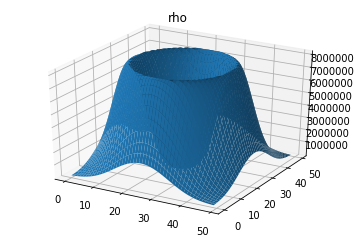

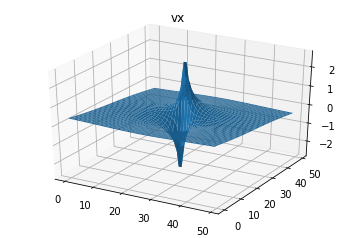

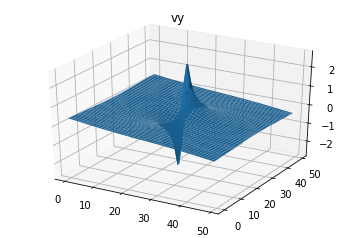

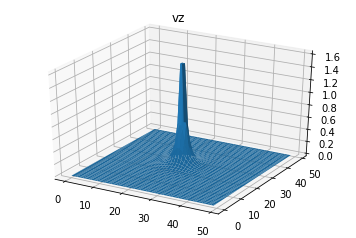

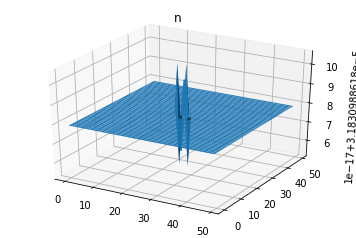

C:\Users\stefs\Anaconda3\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\stefs\Anaconda3\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars


Did  0  iterations


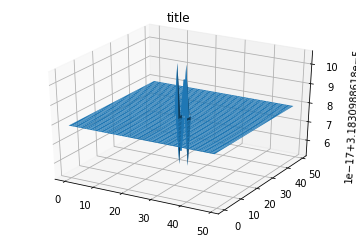

In [ ]:
gradient_descent()
# nav is roughly constant because the perturbed part is << omega, need to come up with 
# sensible values of parameters / rescale the equations